<a href="https://colab.research.google.com/github/nurrizkyimani/mesh_on_demand/blob/brach_colab/Data_Mining_Nurrizky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [21]:
# {"username":"bocahrokok","key":"3470fa29c5901d007de08e0f97175435"}

import os 
os.environ['KAGGLE_USERNAME'] = "bocahrokok" 
os.environ['KAGGLE_KEY'] = "e84247255109e51ea31886308e848c7f"


# kaggle datasets download -d takuok/glove840b300dtxt

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/datamining/"


In [22]:
%cd /content/drive/MyDrive/datamining/

/content/drive/MyDrive/datamining


In [23]:
!kaggle datasets download -d takuok/glove840b300dtxt --unzip

 99% 2.07G/2.08G [00:30<00:00, 121MB/s]
100% 2.08G/2.08G [00:30<00:00, 73.5MB/s]


# Import 

In [3]:
# !pip install spacy==2.3.0
# import spacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bionlp13cg_md-0.2.5.tar.gz
# import en_ner_bionlp13cg_md
!pip install spacy==2.3.5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
import re, nltk, spacy, gensim
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from bs4 import BeautifulSoup
from nltk.tokenize import ToktokTokenizer
from nltk.stem import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from string import punctuation
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from keras.metrics import top_k_categorical_accuracy
from keras.optimizer_v2.adam import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import string
import itertools
import io
import json

     |████████████████████████████████| 10.4 MB 5.5 MB/s 
     |████████████████████████████████| 1.0 MB 37.5 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 7.8 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=8b1b03b82e1234360d54f3e82628848affa49eb07e71cf19720d8d63f59ba6d3
  Stored in directory: /root/.cache/pip/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
[nltk_data] Downloading package stop

# Data loading

In [4]:
path = "/content/drive/MyDrive/datamining/"
indonesia_txt = path + "pubmed-indonesia-set.txt"
headache_txt = path + "pubmed-headache-set.txt"
longevity_txt = path + "pubmed-longevity-set.txt"
txt_labels = ["indonesia", "headache", 'longevity']
txt_paths = [indonesia_txt, headache_txt, longevity_txt]



In [9]:
#load file glove untuk embedding
glove_file = "/content/drive/MyDrive/datamining/glove.840B.300d.txt"
emb_dict = {}
glove = open(glove_file, encoding="utf-8")
for line in glove:
  values = line.split()
  word = values[0]
  try :
    vector = np.asarray(values[1:], dtype="float32")
  except :
    continue
  emb_dict[word] = vector
glove.close()

In [10]:
def get_abstract_and_mh(lines):
  s = "".join(lines)
  s = re.sub("\n\s+", "", s)
  s = s.strip()
  s = s.split("\n")

  abstract = ""
  mh = []
  for line in s:
    if line[0:5]=="AB  -":
      abstract = line[6:]
    elif line[0:5]=="MH  -":
      mh.append(line[6:])
  return [abstract, mh]

In [11]:
records = []
for i, p in enumerate(txt_paths):
  f = open(p, "r")
  temp_record = []
  r = []
  for line in f:
    if line != "\n":
      r.append(line)
    else :
      temp_record.append(get_abstract_and_mh(r))
      r = []
  f.close()
  records.append(temp_record)

In [36]:
records[0][1]

['Recent advances in the diagnosis and management of pulmonary arterial hypertension (PAH) have led to a significant improvement in the outcomes for patients with PAH. However, prompt and accurate diagnosis of PAH remains an unmet challenge due to lack of awareness and lack of meticulous data to profile the etiology and pathophysiology of this rare progressive disease, especially in low- and middle-income country. In Indonesia, the true prevalence and incidence of different subtypes of PAH in general population is still unknown. The Congenital HeARt Disease in adult and Pulmonary Hypertension (COHARD-PH) registry was the first single-center prospective registry in Indonesia, which indicated that almost 80% of adult patients with congenital heart disease (CHD) had experienced PAH and even Eisenmenger syndrome due to delayed diagnosis. Screening for early detection of asymptomatic CHD in children is yet to be systematically established in Indonesia, leading to undiagnosed and uncorrected

# Preprocessing

In [12]:
token = ToktokTokenizer()
stop_words = set(stopwords.words("english"))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
punct = punctuation

def clean_text(text):
    ''' Lowering text and removing undesirable marks
    '''
    
    text = re.sub("\d+", "", text)
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text) # matches all whitespace characters
    text = text.strip(' ')
    return text
  
def strip_list_noempty(mylist):
    
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']
    
    
def clean_punct(text): 
    ''' Remove punctuations'''
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    
    for w in words:
        w = re.sub('^[0-9]*', " ", w)
        punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))
  
def stopWordsRemove(text):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    '''
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))
  
def lemmatization(texts, allowed_postags, stop_words=stop_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the underired POS tags
    
    Parameters:
    
    texts (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADL, VERB, ADV
    '''
    lemma = wordnet.WordNetLemmatizer()       
    doc = nlp(texts) 
    texts_out = []
    
    for token in doc:
        if token.pos_ in allowed_postags:
            
          if token.lemma_ not in ['-PRON-']:
              texts_out.append(token.lemma_)
              
          else:
              texts_out.append('')
     
    texts_out = ' '.join(texts_out)

    return texts_out

In [13]:
for r in records:
  for d in r:
    d[0] = clean_text(d[0])
    d[0] = BeautifulSoup(d[0]).get_text()
    d[0] = clean_punct(d[0])
    d[0] = stopWordsRemove(d[0])
    # d[0] = lemmatization(d[0], ["NOUN", "ADV", "ADL", "VERB"])

In [14]:
records[1][0]

['many types headache moreover many people different types headache time adequate treatment possible basis correct diagnosis technically terms content current diagnostics process headache based international classification headache disorders ichd beta produced auspices international headache society classification based distinction primary secondary headaches common primary headache types tension type headache migraine cluster headache application uniform diagnostic concepts essential come appropriate treatment various types headache',
 ['Headache/*classification/*diagnosis', 'Humans']]

In [15]:
records_combined = list(itertools.chain.from_iterable(records))

# Visualisation

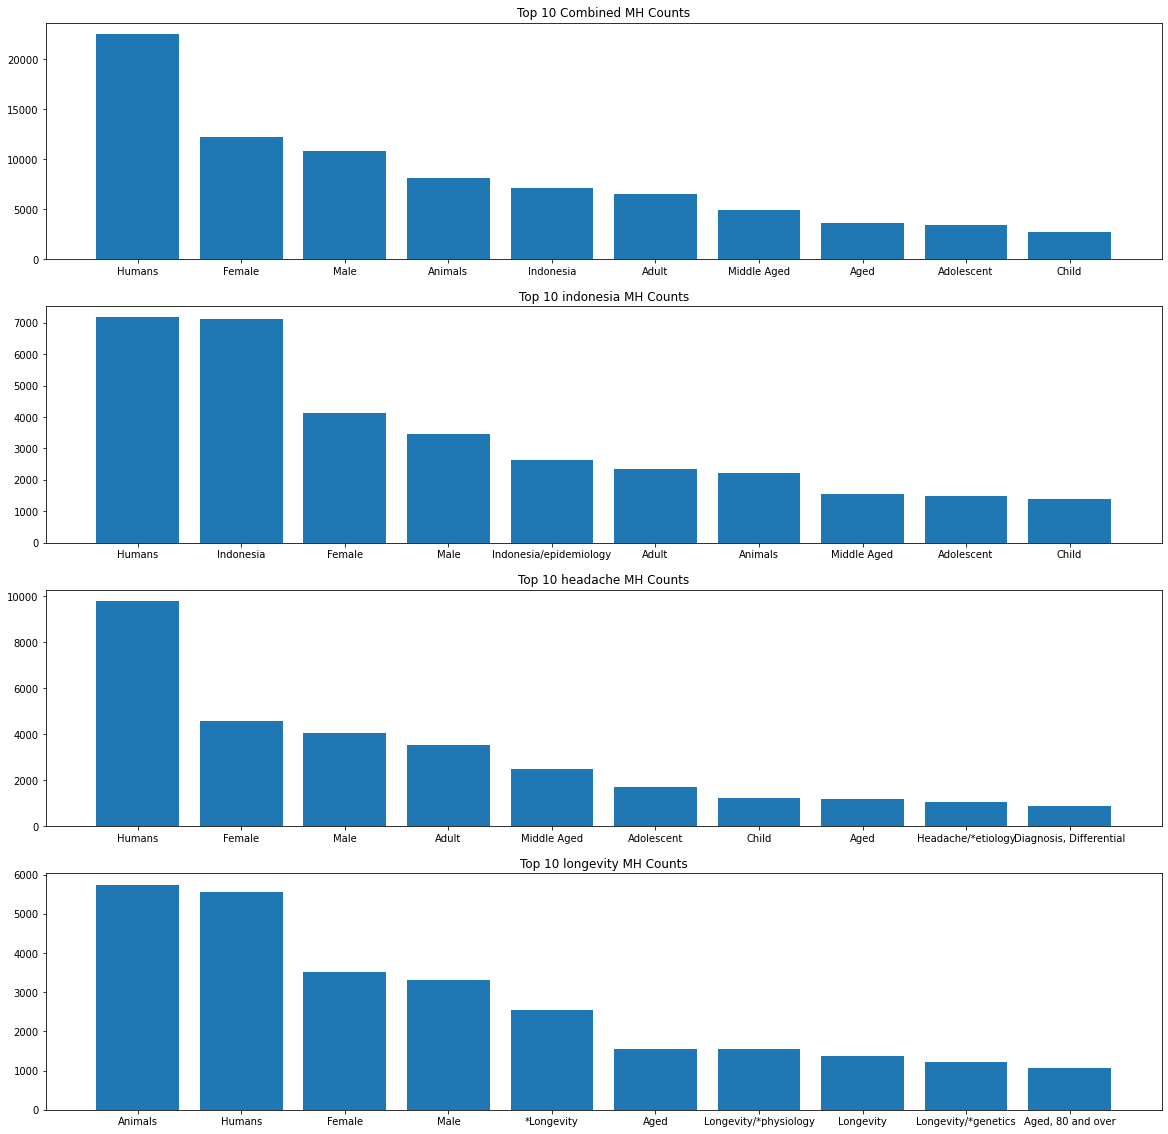

In [40]:
mh_list = []
for d in records_combined:
  mh_list += d[1]
values, counts = np.unique(mh_list, return_counts=True)

fig, axs = plt.subplots(4, figsize=(20, 20))
ind = (-counts).argsort()[:10]
axs[0].set_title("Top 10 Combined MH Counts")
axs[0].bar(values[ind], counts[ind])

for i in range(len(records)):
  mh_list = []
  for d in records[i]:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  axs[i+1].set_title("Top 10 {} MH Counts".format(txt_labels[i]))
  axs[i+1].bar(values[ind], counts[ind])

In [41]:
def show_wordcloud(records, tag, bg_color):
  combined_text = ""
  for r in records:
    if tag in r[1]:
      combined_text += r[0]

  wordcloud = WordCloud(width = 800, height = 800,
                background_color = bg_color,
                min_font_size = 10).generate(combined_text)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

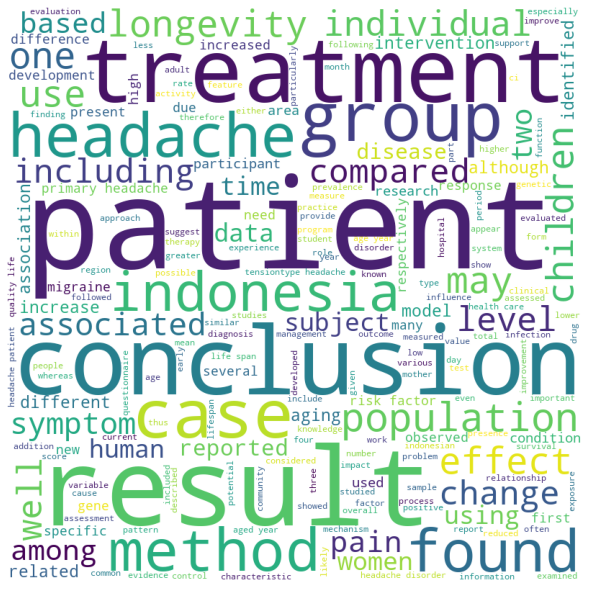

In [42]:
show_wordcloud(records_combined, "Humans", "white")

In [51]:
records_combined[0][1]

['*Betacoronavirus',
 'COVID-19',
 'Coronavirus Infections/*epidemiology',
 'Humans',
 'Indonesia/epidemiology',
 'Pandemics',
 'Pneumonia, Viral/*epidemiology',
 'SARS-CoV-2']

# Logistic Regression-Combined

In [52]:
def one_v_all_learning(records):
  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append(d[1])
  X = np.array(X)
  y = np.array(y)
  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)
  reports = {}
  for i in range(len(top_tags)):
    y_train_temp = [1 if top_tags[i] in row else 0 for row in y_train]
    y_test_temp = [1 if top_tags[i] in row else 0 for row in y_test]
    clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1)
    clf.fit(X_tfidf_train, y_train_temp)
    preds = clf.predict(X_tfidf_test)
    print("Hasil Klasifikasi Kelas {}".format(top_tags[i]))
    print(classification_report(y_test_temp, preds))
    reports[top_tags[i]] = classification_report(y_test_temp, preds, output_dict=True)
  return reports

In [53]:
logreg_report_combined = one_v_all_learning(records_combined)
# report_combined = one_v_all_learning(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
Hasil Klasifikasi Kelas Humans
              precision    recall  f1-score   support

           0       0.85      0.63      0.73      1484
           1       0.89      0.96      0.93      4516

    accuracy                           0.88      6000
   macro avg       0.87      0.80      0.83      6000
weighted avg       0.88      0.88      0.88      6000

Hasil Klasifikasi Kelas Female
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      3564
           1       0.78      0.60      0.68      2436

    accuracy                           0.77      6000
   macro avg       0.77      0.74      0.75      6000
weighted avg       0.77      0.77      0.76      6000

Hasil Klasifikasi Kelas Male
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      3846
           1       0.75      0.54      0.63   

# Logistic Regression-Result Visualization

In [54]:
def get_average_accuracy(reports):
  accuracy = [r["accuracy"] for r in list(reports.values())]
  return sum(accuracy)/len(accuracy)

def get_average_precision(reports):
  precision = [r["1"]["precision"] for r in list(reports.values())]
  return sum(precision)/len(precision)

def get_average_recall(reports):
  recall = [r["1"]["recall"] for r in list(reports.values())]
  return sum(recall)/len(recall)

def get_average_f1(reports):
  f1 = [r["1"]["f1-score"] for r in list(reports.values())]
  return sum(f1)/len(f1)

<BarContainer object of 1 artists>

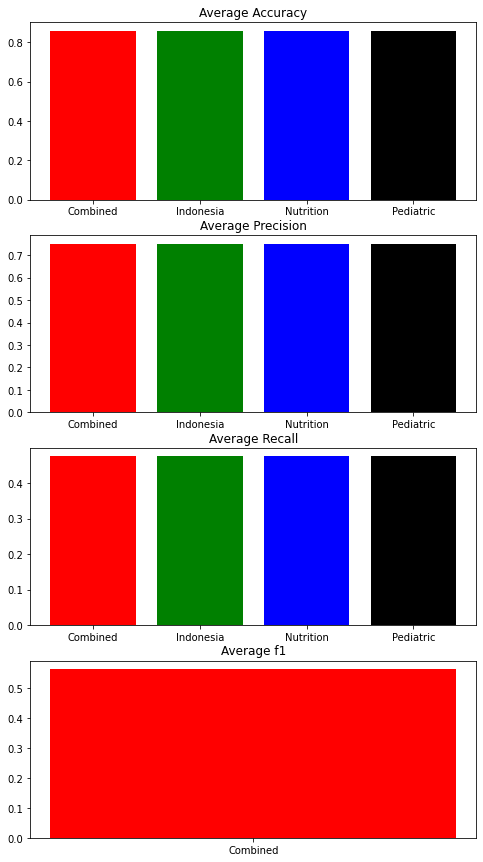

In [56]:
fig, axs = plt.subplots(4, figsize=(8, 15))
color = ["red", "green", "blue", "black"]

report_combined = logreg_report_combined

axs[0].set_title("Average Accuracy")
acc_vals = [
            get_average_accuracy(report_combined),
            # get_average_accuracy(report_indo),
            # get_average_accuracy(report_nutrition),
            # get_average_accuracy(report_pediatric)
]
axs[0].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    acc_vals,
    color = color
)

axs[1].set_title("Average Precision")
precision_vals = [
            get_average_precision(report_combined),
            # get_average_precision(report_indo),
            # get_average_precision(report_nutrition),
            # get_average_precision(report_pediatric)
]
axs[1].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    precision_vals,
    color = color
)

axs[2].set_title("Average Recall")
recall_vals = [
            get_average_recall(report_combined),
            # get_average_recall(report_indo),
            # get_average_recall(report_nutrition),
            # get_average_recall(report_pediatric)
]
axs[2].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    recall_vals,
    color = color
)

axs[3].set_title("Average f1")
f1_vals = [
            get_average_f1(report_combined),
            # get_average_f1(report_indo),
            # get_average_f1(report_nutrition),
            # get_average_f1(report_pediatric)
]
axs[3].bar(
    ["Combined",
    #  "Indonesia", "Nutrition", "Pediatric"
     ],
    f1_vals,
    color = color
)

# LSTM - Combined

In [65]:
def lstm_multilabel_training(records):
  n_top_tags = 100
  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:n_top_tags]
  used_mh = values[ind]

  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append([mh for mh in d[1] if mh in used_mh])
  X = np.array(X)
  y = np.array(y)

  # The maximum number of words to be used. (most frequent)
  MAX_NB_WORDS = 30000
  # Max number of words in each abstract.
  MAX_SEQUENCE_LENGTH = 250
  # This is fixed.
  EMBEDDING_DIM = 300

  filter = np.array([len(t)!=0 for t in y])
  X_lstm = np.array(X)[filter]
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X_lstm)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X_lstm = tokenizer.texts_to_sequences(X_lstm)
  X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', X_lstm.shape)
  
  emb_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
  for w, i in tokenizer.word_index.items():
      if i < MAX_NB_WORDS:
          vect = emb_dict.get(w)
          if vect is not None:
            emb_matrix[i] = vect
      else:
          break
  tags = pd.get_dummies(pd.Series(y).apply(pd.Series).stack()).sum(level=0)
  y_lstm = tags.values
  print('Shape of label tensor:', y_lstm.shape)
  X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
        X_lstm,
        y_lstm, 
        test_size = 0.10, 
        random_state = 42)
  
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(n_top_tags, activation='sigmoid'))
  o = Adam(lr=0.001)
  model.compile(loss='binary_crossentropy', optimizer=o, metrics=[top_k_categorical_accuracy])
  model.layers[0].set_weights([emb_matrix])
  model.layers[0].trainable = False

  epochs = 5
  batch_size = 64

  history = model.fit(X_lstm_train, y_lstm_train, epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])
  
  accr = model.evaluate(X_lstm_test,y_lstm_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  return model, accr[1]

In [ ]:
model, lstm_acc_combined = lstm_multilabel_training(records_combined)
print(lstm_acc_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


Found 76969 unique tokens.
Shape of data tensor: (29934, 250)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


Shape of label tensor: (29934, 100)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
379/379 [==============================] - 464s 1s/step - loss: 0.1492 - top_k_categorical_accuracy: 0.4415 - val_loss: 0.1210 - val_top_k_categorical_accuracy: 0.4603
Epoch 2/10
379/379 [==============================] - 487s 1s/step - loss: 0.1144 - top_k_categorical_accuracy: 0.4839 - val_loss: 0.1119 - val_top_k_categorical_accuracy: 0.5074
Epoch 3/10
379/379 [==============================] - 487s 1s/step - loss: 0.1086 - top_k_categorical_accuracy: 0.4904 - val_loss: 0.1077 - val_top_k_categorical_accuracy: 0.5063
Epoch 4/10
379/379 [==============================] - 455s 1s/step - loss: 0.1046 - top_k_categorical_accuracy: 0.4995 - val_loss: 0.1054 - val_top_k_categorical_accuracy: 0.4881
Epoch 5/10
379/379 [==============================] - 451s 1s/step - loss: 0.1018 - top_k_categorical_accuracy: 0.5027 - val_loss: 0.1040 - val_top_k_categorical_accuracy: 0.5141
Epoch 6/10
379/379 [==============================] - 446s 1s/step - loss: 0.0996 - top_k_categorical_acc

# Clustering Method

In [16]:
records_combined[0]

['coronavirus disease covid pandemic ongoing problem countries world indonesia greatly affected covid case fatality rate cfr end march room improvement related unreadingess healthcare facility major steps taken government suggested country stricter stayathome notice suppress spread imposing lockdown large scale improve healthcare service increase availability personal protective equipments ppe important avoid epidemic peak potentially overwhelms healthcare service quarantining case contacts lockdown may prolong epidemic doubling time significantly demand health system likely grow since number covid case likely rise effective procedures protecting medical staff infection essential scientific research indonesia also crucial provide suggestion recommendation pertinent covid',
 ['*Betacoronavirus',
  'COVID-19',
  'Coronavirus Infections/*epidemiology',
  'Humans',
  'Indonesia/epidemiology',
  'Pandemics',
  'Pneumonia, Viral/*epidemiology',
  'SARS-CoV-2']]

In [25]:
def clustering_kmeans(records):
  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append(d[1])
  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))

  return X_tfidf_train, X_tfidf_test, top_tags








In [26]:
X_tfidf_train, X_tfidf_test, top_tags = clustering_kmeans(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def clustering_kmeans(records):
  X = []
  y = []

  for d in records:
    X.append(d[0])
    y.append(d[1])

  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))


  true_k = len(top_tags)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
  model.fit(X_tfidf_train)

  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer_X.get_feature_names()
  for i in range(true_k):
      print("Cluster %d:" % i),
      for ind in order_centroids[i, :10]:
          print(' %s' % terms[ind]),
      print

  print("\n")
  print("Prediction")

  return X_tfidf_test

In [67]:
X_tfidf_test = clustering_kmeans(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Top terms per cluster:
Cluster 0:
 absence
 addition
 address
 based
 analysis
 detection
 evidence
 areas
 childhood
 additional
Cluster 1:
 acid
 ability
 accumulation
 across
 according
 activities
 body
 concentrations
 antioxidant
 fish
Cluster 2:
 ability
 acid
 absence
 across
 adverse
 additional
 account
 ageing
 activity
 aged
Cluster 3:
 activities
 according
 active
 addition
 aging
 along
 age
 additional
 among
 area
Cluster 4:
 access
 accumulation
 absence
 action
 acute
 adolescents
 animal
 adverse
 asian
 assessment
Cluster 5:
 absence
 adult
 affect
 ageing
 action
 active
 across
 aim
 adjusted
 according
Cluster 6:
 absence
 account
 across
 addition
 ages
 activities
 according
 aging
 affected
 adjusted
Cluster 7:
 allele
 another
 almost
 among
 agerelated
 antioxidant
 access
 approaches
 absence
 andor
Cluster 8:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [68]:
prediction = model.predict(X_tfidf_test)
print(prediction)

[2 6 6 ... 8 2 8]


In [71]:
rs = X_tfidf_test[1].reshape(1,-1)
prediction_test = model.predict(rs)
print(prediction_test)

[6]
